# Stage 4: Compare Previous Violations History With Stim Interactions

**Goal**: Repeat analysis comparing multi-models with differing regressors (prev viol binary, prev viol exp kernel, stim x prev viol interactions) with animals only in stage 4 and mostly trained. 

Similar to the 2023_11_16 experiment but with updated dataset/prev violation taus.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from fitting_utils import create_violation_interaction_pairs
from experiment_compare_models import ExperimentCompareModels
from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import ModelVisualizerCompare
from design_matrix_generator import DesignMatrixGeneratorFilteredHistory, DesignMatrixGeneratorInteractions
sns.set_context("talk")
%load_ext autoreload
%autoreload 2

In [4]:
stg4_animals = [
    "W051",
    "W060",
    "W065",
    "W068",
    "W072",
    "W073",
    "W074",
    "W075",
    "W078",
    "W080",
    "W082",
    "W083",
    "W088",
    "W089",
]

model_config = {
    "psytrack_features": {  # MODEL 1- pystrack multi base
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
    },
    "filter_prev_violation": {  # MODEL 2- with filt prev violation history
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
    },
    "filter_prev_violation_stim_itrx": {  # MODEL 3- with filt prev violation history and interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
    },
}
params = {
    "animals": stg4_animals,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "multi",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
    "min_training_stage": 4,
}

In [5]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(
    file_name="2024_01_18_stg4_compare_prev_violation_stim_interactions.pkl"
)

returning viol data for ['W051', 'W060', 'W065', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W082', 'W083', 'W088', 'W089']
minimum training stage is  4

 >>>> evaluating animal W051 <<<<

 ***** evaluating model psytrack_features w/ sigma 0.07 *****
         Current function value: 37953.489517
         Iterations: 21
         Function evaluations: 97
         Gradient evaluations: 85

 ***** evaluating model psytrack_features w/ sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 37887.932830
         Iterations: 20
         Function evaluations: 32
         Gradient evaluations: 32

 ***** evaluating model psytrack_features w/ sigma 0.25 *****
Optimization terminated successfully.
         Current function value: 37867.626163
         Iterations: 21
         Function evaluations: 38
         Gradient evaluations: 38

 ***** evaluating model psytrack_features w/ sigma 0.5 *****
Optimization terminated successfully.
         Current fun

In [6]:
ORDER = [
    "psytrack_features",
    "filter_prev_violation",
    "filter_prev_violation_stim_itrx",
]

In [52]:
mvc = ModelVisualizerCompare(experiment)
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)

# Sort the DataFrame
df = df.sort_values("model_name")

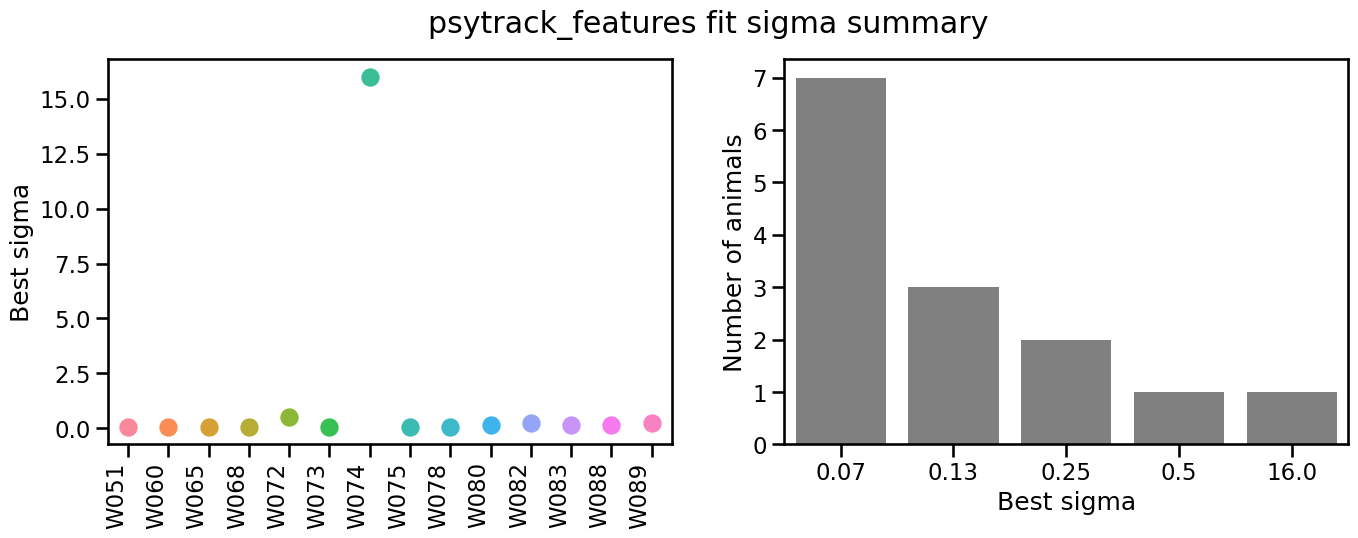

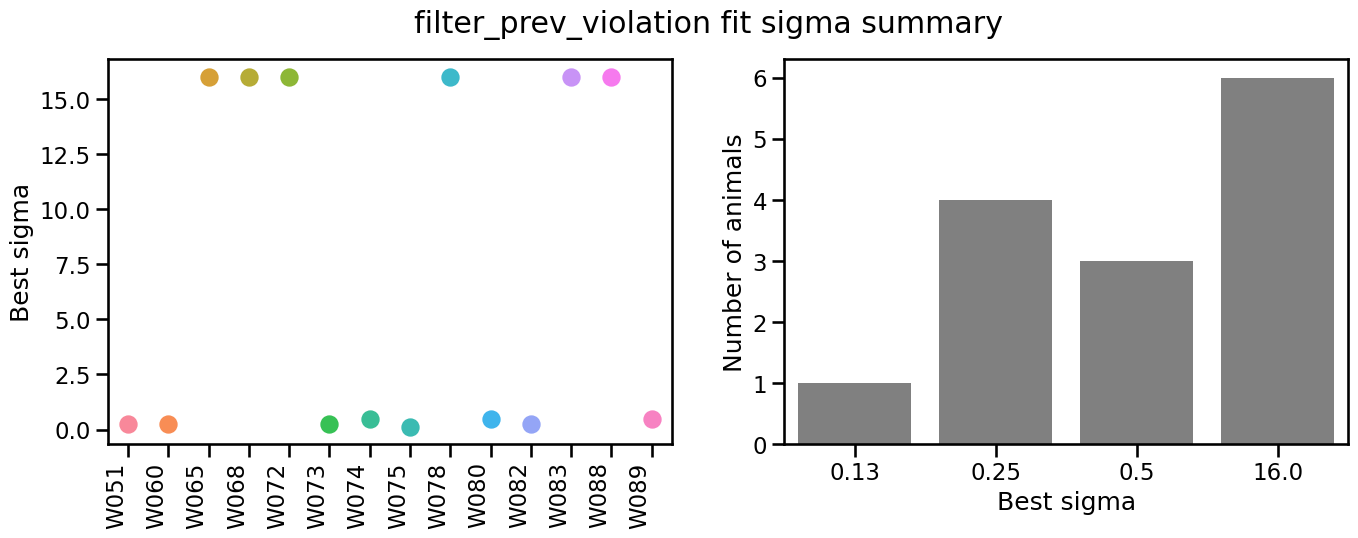

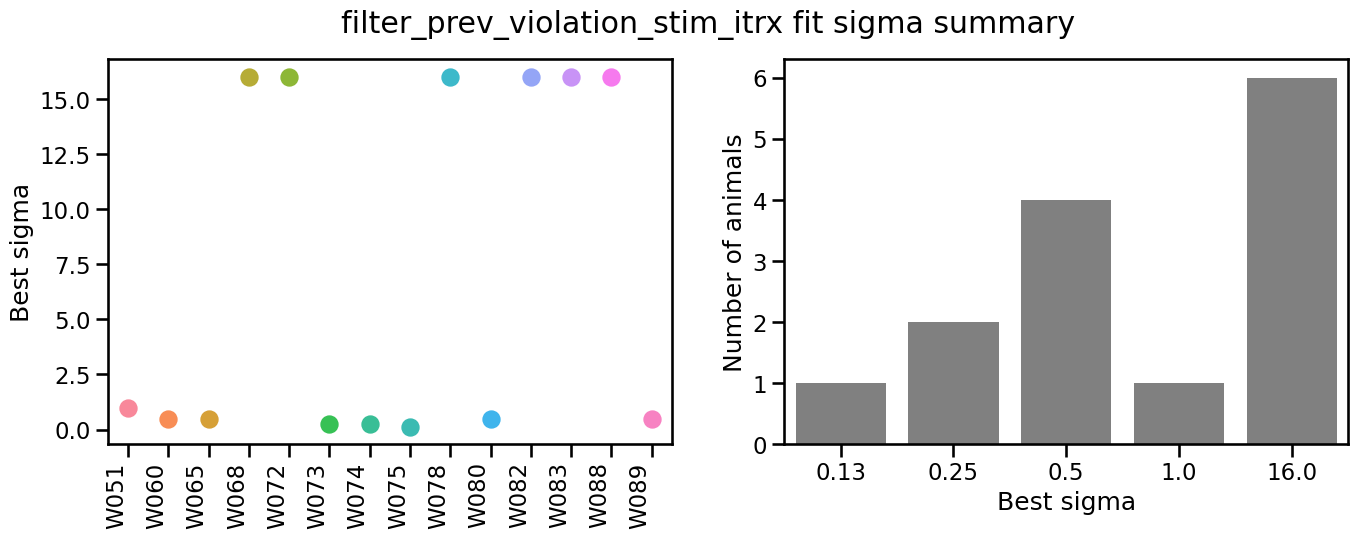

In [8]:
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

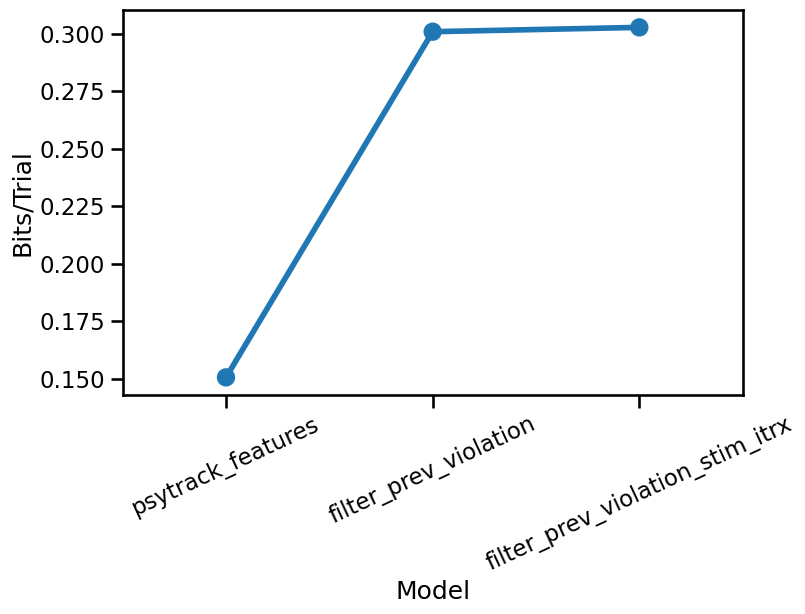

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER,
    errorbar=None,
)

In [27]:
mvc.bits_per_trial_df.groupby("model_name").bits_per_trial.mean()

model_name
filter_prev_violation              0.300931
filter_prev_violation_stim_itrx    0.302813
null                              -1.533522
psytrack_features                  0.150516
Name: bits_per_trial, dtype: float64

In [29]:
0.302813 - 0.300931

0.0018819999999999948

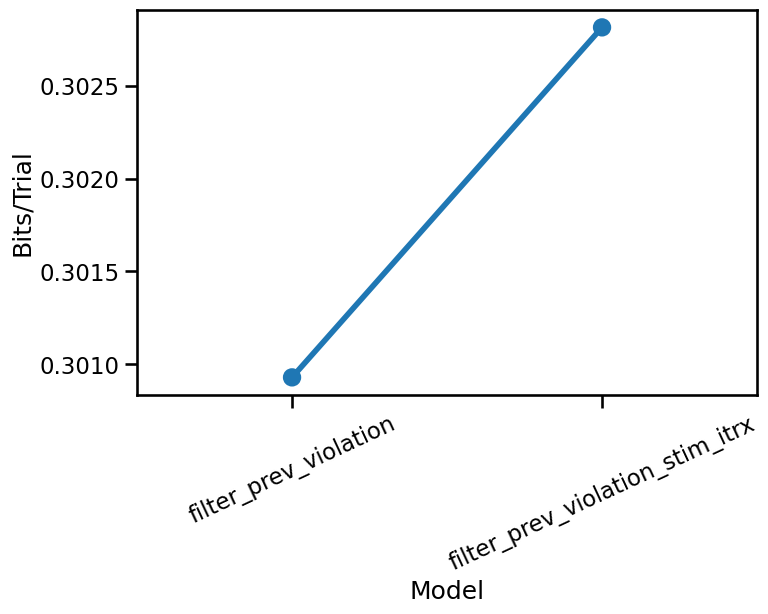

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER[1:],
    errorbar=None,
)

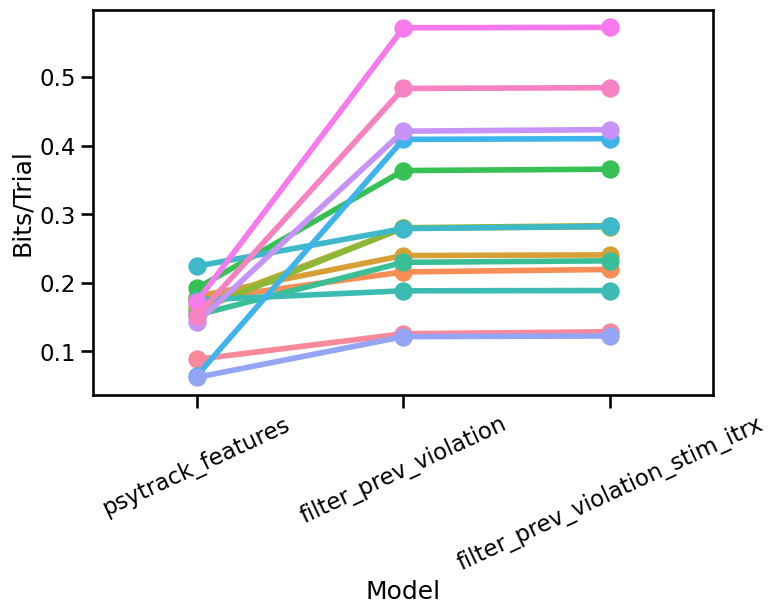

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="animal_id",
    ax=ax,
    order=ORDER,
)

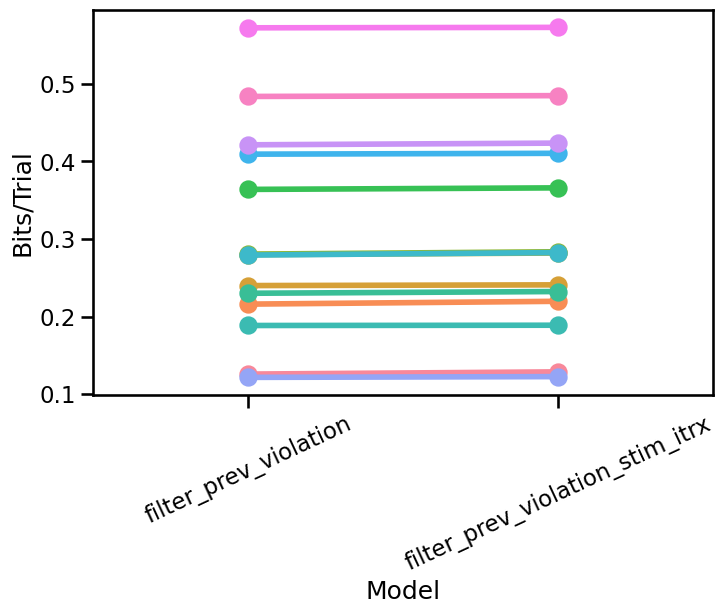

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="animal_id",
    ax=ax,
    order=ORDER[1:],
)

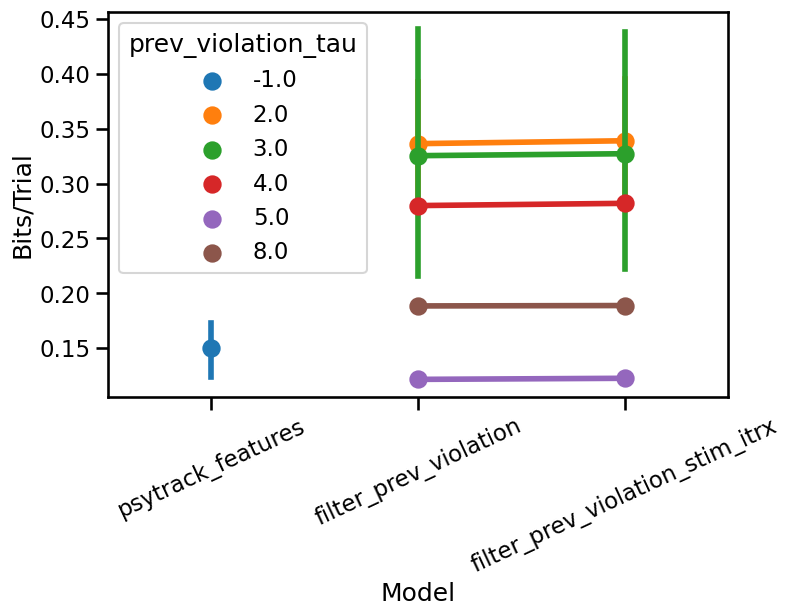

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="prev_violation_tau",
    ax=ax,
    order=ORDER,
    # ylim=(0, 0.6),
)

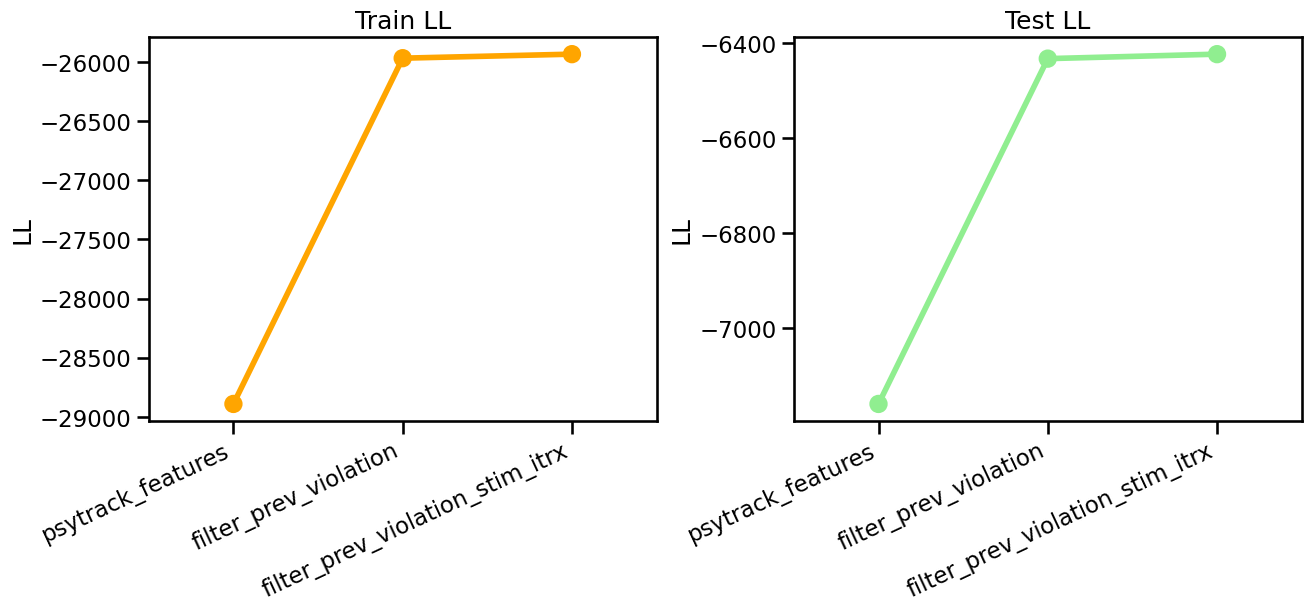

In [21]:
mvc.plot_train_and_test_ll(
    order=ORDER,
    errorbar=None,
)

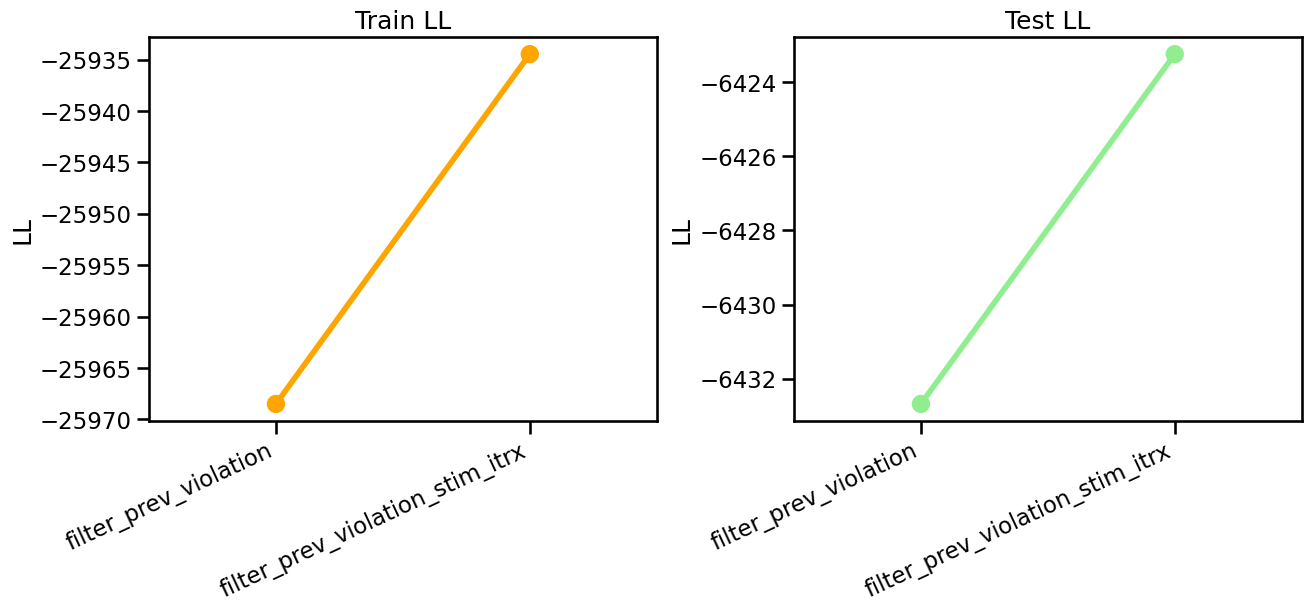

In [30]:
mvc.plot_train_and_test_ll(
    order=ORDER[1:],
    errorbar=None,
)

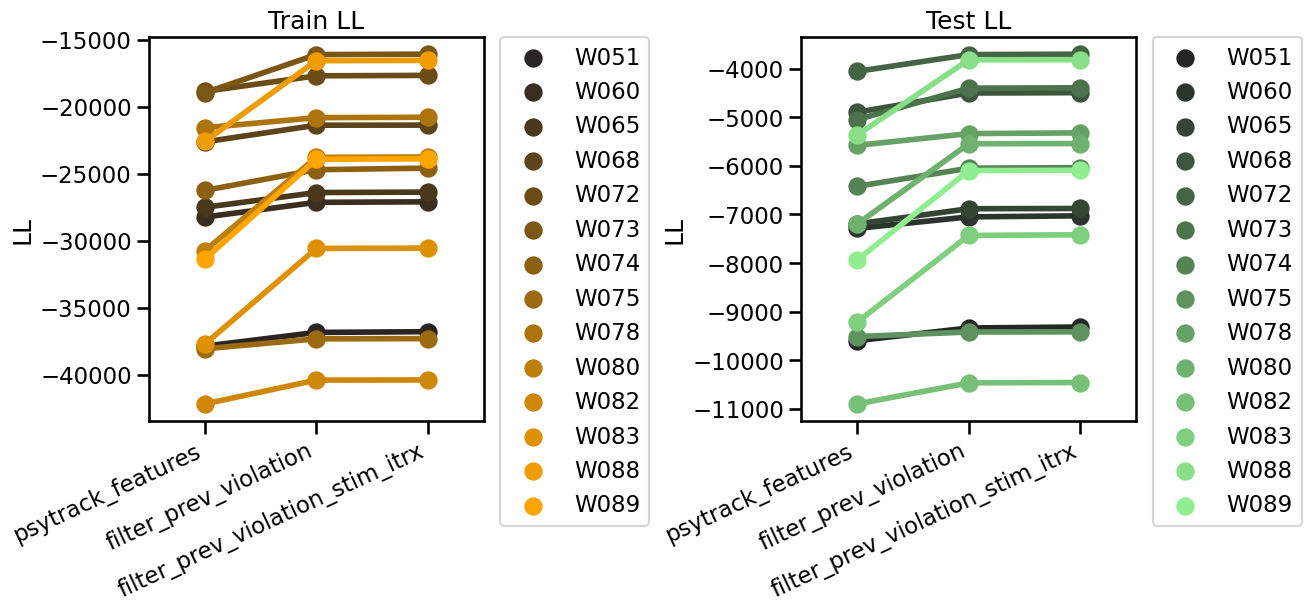

In [22]:
mvc.plot_train_and_test_ll(
    order=ORDER,
    errorbar=None,
    hue="animal_id",
)

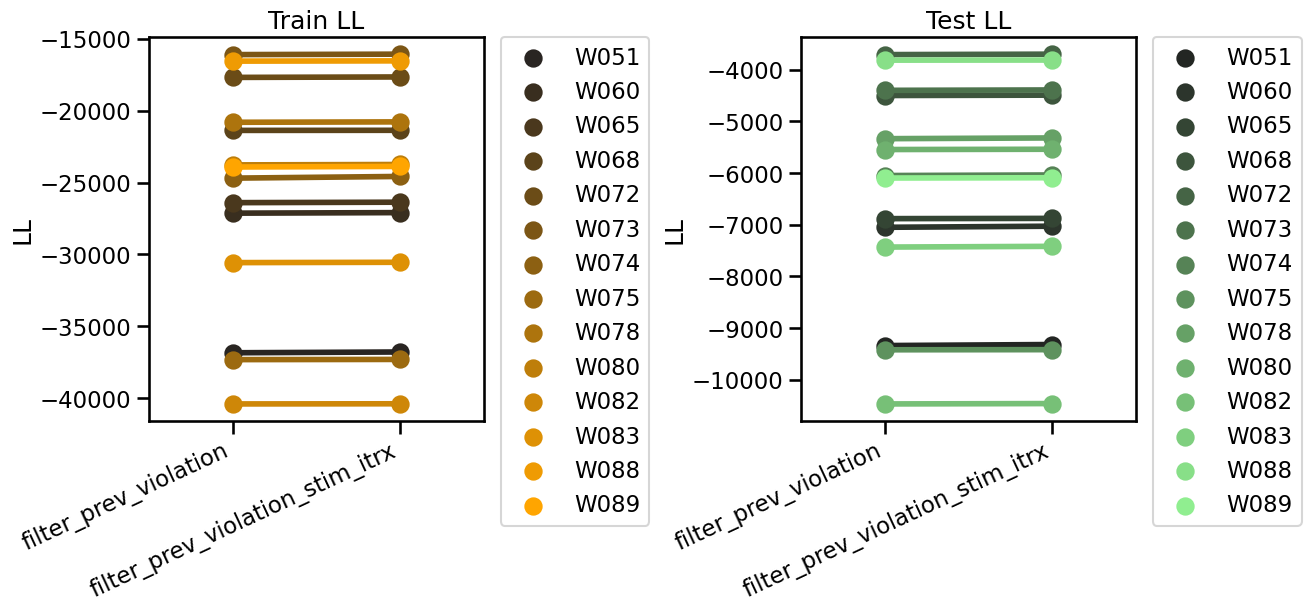

In [23]:
mvc.plot_train_and_test_ll(
    order=ORDER[1:],
    errorbar=None,
    hue="animal_id",
)

In [24]:
train_df = mvc.find_best_fit(["animal_id", "model_name"], mode="train")
test_df = mvc.find_best_fit(["animal_id", "model_name"], mode="test")

In [25]:
train_df.groupby(["model_name"]).train_nll.mean()
train_df.groupby(["model_name"]).train_nll.mean()

model_name
filter_prev_violation              25968.496271
filter_prev_violation_stim_itrx    25934.476705
psytrack_features                  28890.137091
Name: train_nll, dtype: float64

<Axes: title={'center': 'Model Improvement- mu: 736.08 std: 656.63 \n psytrack_features -> filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

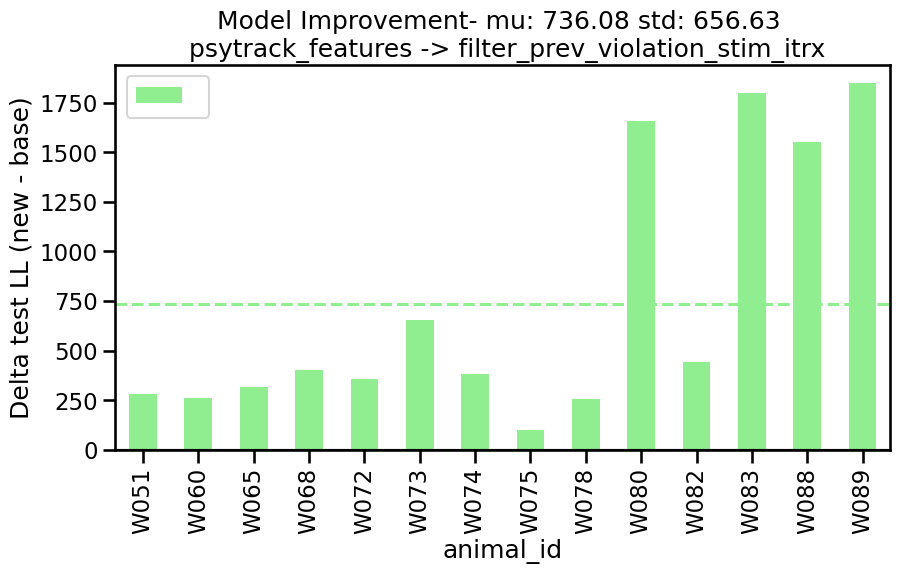

In [57]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[2],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 9.43 std: 5.99 \n filter_prev_violation -> filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

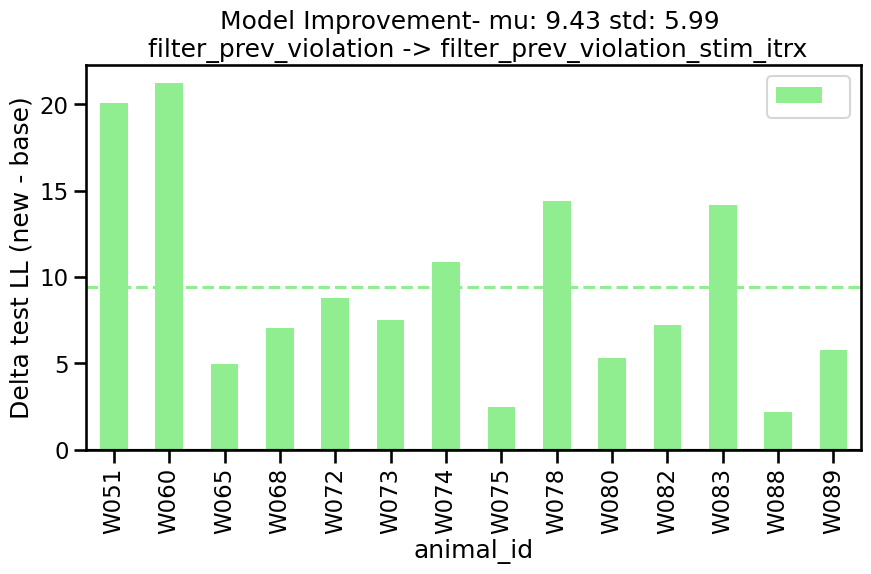

In [58]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[1],
    new_model_name=ORDER[2],
    type="test",
)

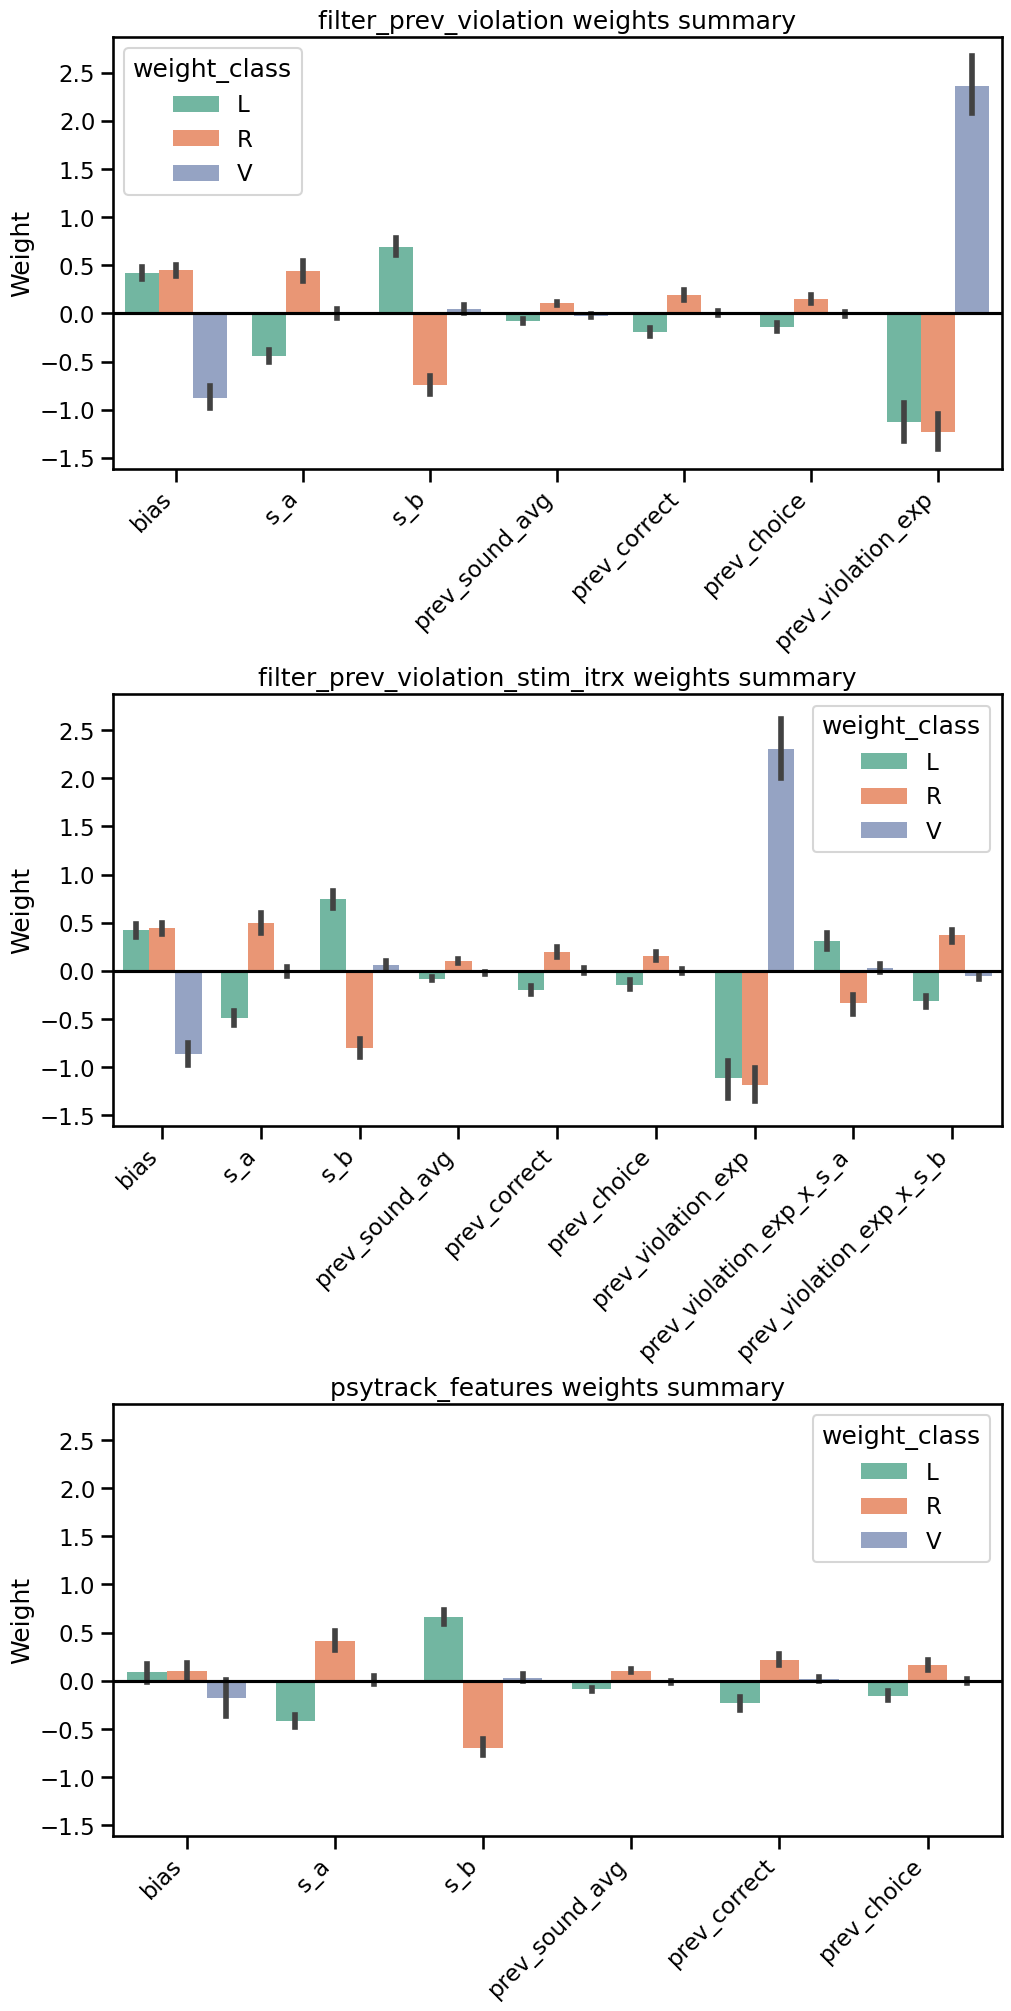

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20), constrained_layout=True, sharey=True)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
# best_fit_by_model["model_name"] = pd.Categorical(
#     df["model_name"], categories=ORDER, ordered=True
# )
# best_fit_by_model = best_fit_by_model.sort_values("model_name")
for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

**Summary**: Results are similar when repeating analysis with the stage 4 animals, although the magnitude is smaller. Adding in interaction terms is a strict improvement to all animals when comparing to only having a prev violation history regressor. It will be interesting to see if and how these results change when other animals are added back into the dataset.